# Imports básicos para todas as análises

In [2]:
# import os
# Verificando se isso aqui resolve o CUDAOutOfMemory 
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
import warnings

import mlforecast as mlf
import numpy as np
import optuna as opt
import pandas as pd
import plotly.graph_objects as go

from datetime import datetime
from functools import partial
from plotly.subplots import make_subplots

from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

from mlforecast.utils import PredictionIntervals
from sklearn.tree import DecisionTreeRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAPE, MQLoss

# A ser usado apenas para a análise de imputação de dados (ao invés de sempre aplicar o valor médio)
from sklearn.impute import KNNImputer

from sktime.param_est.seasonality import SeasonalityACF
from sktime.param_est.stationarity import StationarityADF
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
)

from sktime.split import temporal_train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import (
    acf,
    pacf
)

# Desativar as mensagens de 'warning' que ficam poluindo o output de alguns trechos de código.
warnings.filterwarnings("ignore")

# Para com a verborragia do log do Optuna
opt.logging.set_verbosity(opt.logging.WARNING)

# Wraper pra usar a engine do Plotly ao invocar a função "[DataFrame|Series].plot" do Pandas
pd.options.plotting.backend = "plotly"

# Métricas utilizadas
mape = MeanAbsolutePercentageError(symmetric=False)  # Melhor valor possível é 0.0
rmse = MeanSquaredError(square_root=True)  # Quanto menor, melhor
mae = MeanAbsoluteError()  # Quanto menor, melhor

SALVAR_PLOTS = True
SEED = 1984

pasta_resultados = "./resultados/trecho_baixo/"

# Utilidades

In [3]:
def decomp_series(
    df: pd.DataFrame,
    tendencia: bool,
    sazonalidade: bool,
    residuo: bool,
    salvar: bool = False,
) -> None:
    # A decomposição das séries temporais ajuda a detectar padrões (tendência, sazonalidade)
    #   e identificar outras informações que podem ajudar na interpretação do que está acontecendo.

    cols = df.drop(columns=["ds", "unique_id"]).columns.to_list()
    for c in cols:
        
        # Utilizei modelo do tipo "add" (aditivo) pois tem séries com valores 0 (zero).
        # Período de 365 dias porque o que me interessa é capturar comportamentos anuais.
        decomp = seasonal_decompose(
            df[c],
            period=365, # 365 dias = 1 ano
            model="add"
        )
        fig_decomp = make_subplots(specs=[[{"secondary_y": True}]])

        fig_decomp.add_trace(
            go.Scatter(
                x=df.ds,
                y=decomp.observed,
                name="observado",
                mode="lines",
                showlegend=True,
            ),
            secondary_y=False,
        )

        if tendencia:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.trend,
                    name="tendência",
                    mode="lines",
                    showlegend=True,
                ),
                secondary_y=True,
            )

        if sazonalidade:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.seasonal,
                    name="sazonalidade",
                    mode="lines",
                    showlegend=True,
                ),
                secondary_y=True,
            )

        if residuo:
            fig_decomp.add_trace(
                go.Scatter(
                    x=df.ds,
                    y=decomp.resid,
                    name="resíduo",
                    mode="lines",
                    showlegend=True,
                ),
                secondary_y=False,
            )

        fig_decomp.update_yaxes(
            title=dict(
                text="observado/resíduo",
                font=dict(family="system-ui", size=18)
            ),
            secondary_y=False,
            zerolinecolor="black",
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig_decomp.update_yaxes(
            title=dict(
                text="tendência/sazonalidade",
                font=dict(family="system-ui", size=18)
            ),
            secondary_y=True,
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig_decomp.update_xaxes(
            title=dict(
                text="Período",
                font=dict(family="system-ui", size=18)
            ),
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig_decomp.update_layout(
            width=1500,
            height=700,
            plot_bgcolor="#c8d4e3",
            hovermode="x unified",
            title=dict(
                text="Decomposição da série temporal: {col}".format(col=c),
                font=dict(family="system-ui", size=24),
            ),
        )

        if salvar:
            fig_decomp.write_image(
                pasta_resultados+"aed/decomposicao_serie_{}.png".format(c)
            )
        else:
            fig_decomp.show()
# ============================================================================================ #
def estacionariedade(
    df: pd.DataFrame,
    sp: int
) -> None:

    # Avaliar a estacionariedade de cada uma das séries e a sazonalidade (se houver)
    # Existindo sazonalidade, qual a lag (ou quais lags) se encaixam nesta sazonalidade
    cols = df.drop(columns=["ds", "unique_id"]).columns.to_list()
    for c in cols:
        ts = df[c]
        sty_est = StationarityADF()
        sty_est.fit(ts)
        print(c, sty_est.get_fitted_params()["stationary"])

        # Este teste de sazonalidade deve ser aplicado a séries estacionárias.
        # Se precisar tornar uma série em estacionária, tem de aplicar diferenciação antes.
        if sty_est.get_fitted_params()["stationary"]:
            sp_est = SeasonalityACF( # Minha intenção é ter certeza de que existe sazonalidade anual (365 dias)
                candidate_sp=sp,
                nlags=len(df[c])
            )
            sp_est.fit(ts)
            sp_est.get_fitted_params()
            print(c, sp_est.get_fitted_params()["sp_significant"])
# ============================================================================================ #
def mapa_correlacao(
    df: pd.DataFrame,
    medida: str = "dtw",
    salvar: bool = False
) -> None:

    if medida == "dtw":
        from dtaidistance import dtw

        dtw_dist = dtw.distance_matrix_fast(df.drop(columns=["ds", "unique_id"]).T.values)
        
        df_dtw_dist = pd.DataFrame(
            data=dtw_dist,
            index=df.drop(columns=["ds", "unique_id"]).columns.to_list(),
            columns=df.drop(columns=["ds", "unique_id"]).columns.to_list(),
        )

        fig = go.Figure()

        fig.add_trace(
            go.Heatmap(
                x=df_dtw_dist.columns,
                y=df_dtw_dist.columns,
                z=df_dtw_dist,
                text=df_dtw_dist.values,
                texttemplate="%{text:.7f}",
                textfont={"size": 14},
                colorscale="rainbow",
                hovertemplate="%{y}<br>%{x}</br><extra></extra>",
            )
        )

        fig.update_yaxes(
            tickfont=dict(family="system-ui", size=14),
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_xaxes(
            tickfont=dict(family="system-ui", size=14),
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_layout(
            width=1500,
            height=700,
            title=dict(text="Mapa de correlação (DTW)", font=dict(family="system-ui", size=24)),
        )

    elif medida == "pearson":

        corr = df.drop(columns=["ds", "unique_id"]).corr()

        fig = go.Figure()

        fig.add_trace(
            go.Heatmap(
                x=corr.columns,
                y=corr.columns,
                z=corr,
                text=corr.values,
                texttemplate="%{text:.7f}",
                textfont={"size": 14},
                colorscale="rainbow",
                hovertemplate="%{y}<br>%{x}</br><extra></extra>",
            )
        )

        fig.update_yaxes(
            tickfont=dict(family="system-ui", size=14),
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_xaxes(
            tickfont=dict(family="system-ui", size=14),
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_layout(
            width=1500,
            height=700,
            title=dict(
                text="Mapa de correlação (coeficiente de Pearson)",
                font=dict(family="system-ui", size=24),
            ),
        )

    else:
        raise Exception("Opção errada. ('dtw' ou 'pearson')")

    if salvar:
        fig.write_image(
            pasta_resultados+"aed/mapa_correlacao_{medida}.png".format(medida=medida)
        )
    else:
        fig.show()
# ============================================================================================ #
def plot_linha_tabela(
    df_merged: pd.DataFrame,
    regressor: str,
    plot_title: str,
    line_color: str,
    short_name: str,
    salvar: bool = False,
) -> None:

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged["ds"],
            y=df_merged["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="#000000", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged["ds"],
            y=df_merged[regressor],
            mode="lines+markers",
            name=short_name,
            line=dict(color=line_color),
        ),
        row=1,
        col=1,
    )

    fig.append_trace(
        go.Table(
            header=dict(
                values=["MAPE", "RMSE", "MAE"],
                font=dict(size=14),
                align="left"
            ),
            cells=dict(
                values=[mape(df_merged.y, df_merged[regressor]), rmse(df_merged.y, df_merged[regressor]), mae(df_merged.y, df_merged[regressor])],
                font=dict(size=12),
                height=24,
                align="left",
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        zerolinecolor="black",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_layout(
        width=1500,
        height=1000,
        hovermode="x unified",
        plot_bgcolor="#c8d4e3",
        title=dict(text=plot_title, font=dict(family="system-ui", size=24)),
    )

    if salvar:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"{reg}_{dt}.png".format(reg=regressor, dt=now.strftime("%Y-%m-%d_%H-%M-%S"))
        )
    else:
        fig.show()
# ============================================================================================ #
def cria_plot_correlacao(
    serie: pd.Series,
    n_lags: int,
    plot_pacf: bool = False,
    salvar: bool = False
) -> None:

    corr_array = (
        pacf(serie.dropna(), nlags=n_lags, alpha=0.05)
        if plot_pacf
        else acf(serie.dropna(), nlags=n_lags, alpha=0.05)
    )

    lower_y = corr_array[1][:, 0] - corr_array[0]
    upper_y = corr_array[1][:, 1] - corr_array[0]

    fig = go.Figure()

    # Desenha as linhas verticais pretas
    [
        fig.add_scatter(
            x=(x, x),
            y=(0, corr_array[0][x]),
            mode="lines",
            line_color="black",
            hovertemplate="<extra></extra>",
        )
        for x in range(len(corr_array[0]))
    ]

    # Desenha as bolinhas vermelhas
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=corr_array[0],
        mode="markers",
        marker_color="red",
        marker_size=12,
        hovertemplate="x = %{x}<br>y = %{y}<extra></extra>",
    )

    # Desenha a 'nuvem' clarinha acima do eixo x
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=upper_y,
        mode="lines",
        line_color="rgba(255,255,255,0)",
        hovertemplate="<extra></extra>",
    )

    # Desenha a 'nuvem' clarinha abaixo do eixo x
    fig.add_scatter(
        x=np.arange(len(corr_array[0])),
        y=lower_y,
        mode="lines",
        fillcolor="rgba(32, 146, 230,0.3)",
        fill="tonexty",
        line_color="rgba(255,255,255,0)",
        hovertemplate="<extra></extra>",
    )

    fig.update_traces(showlegend=False)

    fig.update_xaxes(
        range=[-1, n_lags + 1],
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_yaxes(
        zerolinecolor="black",  # Quando 'y=0' a linha é preta
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    title = (
        "Autocorrelação Parcial (PACF) para n_lags={n}".format(n=n_lags)
        if plot_pacf
        else "Autocorrelação (ACF) para n_lags={n}".format(n=n_lags)
    )
    fig.update_layout(
        width=1500,
        height=700,
        plot_bgcolor="#c8d4e3",
        title=dict(text=title, font=dict(family="system-ui", size=24)),
    )

    if salvar:
        (
            fig.write_image(pasta_resultados+"aed/plot_pacf.png")
            if plot_pacf
            else fig.write_image(pasta_resultados+"aed/plot_acf.png")
        )
    else:
        fig.show()
# ============================================================================================ #
def cria_dataframe_futuro(
    df_futr: pd.DataFrame,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    tp_valor: str,
    n_lags: int,
    date_features: list,
    cols: list,
) -> pd.DataFrame:
    
    """
        tp_valor == "ultimo": # Usa o último valor conhecido
        tp_valor == "media":  # Usa o valor médio de cada coluna vazão
        tp_valor == "ml":     # Usa um modelo XGBoost para gerar previsão futuras das vazões auxiliares
    """

    if tp_valor == "ultimo":  # Usa o último valor conhecido
        for c in cols:
            df_futr[c] = df_train[c].iat[-1]

    elif tp_valor == "media":  # Usa o valor médio de cada coluna vazão
        for c in cols:
            df_futr[c] = df_train[c].mean()

    elif tp_valor == "ml":
        from xgboost import XGBRegressor

        for c in cols:
            fcst = mlf.MLForecast(
                models=XGBRegressor(seed=5),
                freq="D",
                lags=[i + 1 for i in range(n_lags)],
                date_features=date_features,
            )

            df_temp = df_train[["ds", "unique_id", c]]

            fcst.fit(
                df_temp,
                id_col="unique_id",
                time_col="ds",
                target_col=c,
                static_features=[],
            )

            df_preds = fcst.predict(h=len(df_futr)).reset_index()  # macetasso pra não dar erro de index
            df_futr[c] = df_preds["XGBRegressor"]

    else:
        raise Exception("Opção inválida! (ultimo | media | ml)")

    df_futr = pd.merge(
        left=df_futr,
        right=df_test.drop(columns=cols + ["y"]),
        on=["ds", "unique_id"],
        how="left",
    )

    return df_futr
# ============================================================================================ #
def distribuicao_dados(
    df_original: pd.DataFrame,
    df_media: pd.DataFrame,
    df_knn: pd.DataFrame,
    salvar: bool = False,
) -> None:

    cols = np.asarray(df_original.drop(columns=["ds", "unique_id"]).columns)

    for c in cols:
        fig = go.Figure()

        fig.add_trace(
            go.Box(
                y=df_original[c].values,
                name="original",
                marker_color="darkblue",
                jitter=0.5,
                pointpos=-2,
                boxpoints="all",
                boxmean="sd",
            )
        )

        fig.add_trace(
            go.Box(
                y=df_media[c].values,
                name="média",
                marker_color="coral",
                jitter=0.5,
                pointpos=-2,
                boxpoints="all",
                boxmean="sd",
            )
        )

        fig.add_trace(
            go.Box(
                y=df_knn[c].values,
                name="kNN",
                marker_color="olive",
                jitter=0.5,
                pointpos=-2,
                boxpoints="all",
                boxmean="sd",
            )
        )

        fig.update_xaxes(
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_yaxes(
            zerolinecolor="black",
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
        )

        fig.update_layout(
            width=1500,
            height=1000,
            plot_bgcolor="#c8d4e3",
            title=dict(
                text="Distribuição {c}".format(c=c),
                font=dict(family="system-ui", size=24),
            ),
        )

        if salvar:
            fig.write_image(
                pasta_resultados+"aed/distribuicao_dados_{}.png".format(c)
            )
        else:
            fig.show()
# ============================================================================================ #
def plot_feature_importance(
    model: str,
    forecaster: mlf.MLForecast,
    fch: str = "",
    salvar: bool = False
) -> None:

    if model in ["LinearRegression", "LinearSVR"]:
        fig = go.Figure(
            data=[
                go.Bar(
                    x=forecaster.ts.features_order_,
                    y=forecaster.models_[model].coef_,
                    showlegend=False,
                )
            ]
        )
    elif model == "LGBMRegressor":
        fig = go.Figure(
            data=[
                go.Bar(
                    x=forecaster.ts.features_order_,
                    y=forecaster.models_[model].feature_importances_,
                    showlegend=False,
                )
            ]
        )
    else:
        raise Exception("Esta opção não existe.")

    fig.update_yaxes(
        title=dict(text="Pesos/Valores", font=dict(family="system-ui", size=18)),
        zerolinecolor="black",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Feature", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_layout(
        width=1500,
        height=700,
        plot_bgcolor="#c8d4e3",
        title=dict(
            text="Feature importance {m} (fch={fch})".format(m=model, fch=fch),
            font=dict(family="system-ui", size=24),
        ),
    )

    if salvar:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"feature_importance/feature_importance_{m}_fch{fch}_{dt}.png".format(m=model, fch=fch, dt=now.strftime("%Y-%m-%d_%H-%M-%S"))
        )
    else:
        fig.show()
# ============================================================================================ #
def exportar_dict_json(
    v_dict: dict,
    pasta: str,
    nome_arq: str
) -> None:

    json_str = json.dumps(v_dict, indent=4)
    with open(pasta + nome_arq, "w") as a:
        a.write(json_str)
# ============================================================================================ #
def plot_divisao_treino_teste(
    df_treino: pd.DataFrame,
    df_teste: pd.DataFrame,
    col_data: str = "ds",
    col_plot: str = "y",
    salvar: bool = False,
) -> None:

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_treino[col_data],
            y=df_treino[col_plot],
            mode="lines",
            name="treino"
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_teste[col_data],
            y=df_teste[col_plot],
            mode="lines",
            name="teste"
        )
    )

    fig.update_yaxes(
        title=dict(
            text="Vazão (m³/s) / Precipitação (mm/dia)",
            font=dict(family="system-ui", size=18)
        ),
        zerolinecolor="black",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(
            text="Período",
            font=dict(family="system-ui", size=18)
        ),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode="x unified",
        plot_bgcolor="#c8d4e3",
        title=dict(
            text="Vazão 'y' (target)",
            font=dict(family="system-ui", size=24)
        ),
    )

    if salvar:
        fig.write_image(
            pasta_resultados+"aed/divisao_treino_teste_{c}.png".format(c=col_plot)
        )
    else:
        fig.show()

# Carregando e imputando dados

In [4]:
df = pd.read_excel(
    "./arquivos_finais/baixo_rio_doce_final.xlsx",
    sheet_name=0,
    index_col=0,
    header=0,
    parse_dates=["Data"],
)

In [5]:
df.columns

Index(['c_cv_01941010', 'c_cv_01941004', 'c_cv_01941006', 't_cv_56994500',
       't_cv_56990850', 't_vz_56990850', 't_cv_56990005', 't_vz_56990005',
       'c_vz_56994500', 'c_vz_56989400', 'c_vz_56989900', 'c_vz_56990000'],
      dtype='object')

In [6]:
# Deixando o DataFrame no padrão que a lib MLForecast obriga
df["unique_id"] = 1
df = df.reset_index()
df = df.rename(columns={
    "Data": "ds",
    "c_vz_56994500": "y"
})

df

,ds,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56994500,t_cv_56990850,t_vz_56990850,t_cv_56990005,t_vz_56990005,y,c_vz_56989400,c_vz_56989900,c_vz_56990000,unique_id
0,2013-01-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,359.721,15.0942,NaN,45.3207,1
1,2013-01-02,4.4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,369.441,14.7624,NaN,38.2480,1
2,2013-01-03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,399.210,14.4332,NaN,40.5407,1
3,2013-01-04,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,369.441,13.7821,NaN,41.7113,1
4,2013-01-05,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,350.104,13.7821,NaN,38.2480,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,NaN,NaN,3.6,1.8,1.6,323.387500,0.4,42.700000,324.263,NaN,NaN,NaN,1
4013,2023-12-28,NaN,NaN,0.0,0.0,0.0,340.245833,0.0,41.113043,331.514,NaN,NaN,NaN,1
4014,2023-12-29,NaN,NaN,0.0,0.0,0.0,446.204167,0.0,51.043478,386.241,NaN,NaN,NaN,1
4015,2023-12-30,NaN,NaN,0.0,52.6,1.8,466.954167,0.4,39.921739,425.074,NaN,NaN,NaN,1


In [7]:
df.columns

Index(['ds', 'c_cv_01941010', 'c_cv_01941004', 'c_cv_01941006',
       't_cv_56994500', 't_cv_56990850', 't_vz_56990850', 't_cv_56990005',
       't_vz_56990005', 'y', 'c_vz_56989400', 'c_vz_56989900', 'c_vz_56990000',
       'unique_id'],
      dtype='object')

In [8]:
# Rearranjando a posição das colunas pra facilitar a leitura

df = df[[
    'ds',
    'unique_id',
    'y',
    'c_cv_01941010',
    'c_cv_01941004',
    'c_cv_01941006',
    't_cv_56994500',
    't_cv_56990850',
    't_cv_56990005',
    't_vz_56990850',
    't_vz_56990005',
    'c_vz_56989400',
    'c_vz_56989900',
    'c_vz_56990000'
]]

In [9]:
# Percentual de dados faltantes, por coluna

print(100 * df.drop(columns=["ds", "unique_id"]).isna().sum() / len(df))

y                 0.074683
c_cv_01941010     3.808813
c_cv_01941004     0.771720
c_cv_01941006     0.000000
t_cv_56994500    24.222056
t_cv_56990850    21.981578
t_cv_56990005    34.727409
t_vz_56990850    30.171770
t_vz_56990005    46.104058
c_vz_56989400     9.111277
c_vz_56989900    37.839183
c_vz_56990000     3.833707
dtype: float64


## Preenchendo com a média

In [10]:
df_media = df.fillna(df.mean())
df_media

,ds,unique_id,y,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56994500,t_cv_56990850,t_cv_56990005,t_vz_56990850,t_vz_56990005,c_vz_56989400,c_vz_56989900,c_vz_56990000
0,2013-01-01,1,359.721,0.0000,0.000000,0.0,0.551971,14.07066,1.39733,429.653466,96.311852,15.094200,74.558213,45.320700
1,2013-01-02,1,369.441,4.4000,0.000000,0.0,0.551971,14.07066,1.39733,429.653466,96.311852,14.762400,74.558213,38.248000
2,2013-01-03,1,399.210,0.0000,0.000000,0.0,0.551971,14.07066,1.39733,429.653466,96.311852,14.433200,74.558213,40.540700
3,2013-01-04,1,369.441,0.0000,0.000000,0.0,0.551971,14.07066,1.39733,429.653466,96.311852,13.782100,74.558213,41.711300
4,2013-01-05,1,350.104,0.0000,0.000000,0.0,0.551971,14.07066,1.39733,429.653466,96.311852,13.782100,74.558213,38.248000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,1,324.263,2.2103,2.568941,3.6,1.800000,1.60000,0.40000,323.387500,42.700000,27.026029,74.558213,78.328656
4013,2023-12-28,1,331.514,2.2103,2.568941,0.0,0.000000,0.00000,0.00000,340.245833,41.113043,27.026029,74.558213,78.328656
4014,2023-12-29,1,386.241,2.2103,2.568941,0.0,0.000000,0.00000,0.00000,446.204167,51.043478,27.026029,74.558213,78.328656
4015,2023-12-30,1,425.074,2.2103,2.568941,0.0,52.600000,1.80000,0.40000,466.954167,39.921739,27.026029,74.558213,78.328656


## Preenchendo com o KNNImputer

In [11]:
# Recomendam aplicar um scaling antes de imputar com o KNNImputer, mas nos testes que realizei deu nenhuma diferença nos resultados
# Então vou reduzir a engenharia de programação e não usar scaling

imputer = KNNImputer(
    n_neighbors=14,
    weights="distance"
)

df_knn = pd.DataFrame(
    data=imputer.fit_transform(df.drop(columns=["ds", "unique_id"])),
    columns=df.drop(columns=["ds", "unique_id"]).columns,
)

df_knn = pd.DataFrame(
    data=df_knn,
    columns=df.drop(columns=["ds", "unique_id"]).columns
)

df_knn = pd.concat(
    [df[["ds", "unique_id"]], df_knn],
    axis=1
)

df_knn

,ds,unique_id,y,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56994500,t_cv_56990850,t_cv_56990005,t_vz_56990850,t_vz_56990005,c_vz_56989400,c_vz_56989900,c_vz_56990000
0,2013-01-01,1,359.721,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,285.934206,49.213142,15.094200,44.509582,45.320700
1,2013-01-02,1,369.441,4.400000,0.000000,0.0,0.000006,7.463826e-07,0.000014,315.544128,41.001884,14.762400,36.848171,38.248000
2,2013-01-03,1,399.210,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,348.594168,49.786464,14.433200,37.670330,40.540700
3,2013-01-04,1,369.441,0.000000,0.000000,0.0,0.000006,1.086170e-06,0.000020,304.758312,39.373821,13.782100,38.445250,41.711300
4,2013-01-05,1,350.104,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,271.220263,44.492068,13.782100,38.401960,38.248000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,1,324.263,0.000000,0.000000,3.6,1.800000,1.600000e+00,0.400000,323.387500,42.700000,17.123954,34.211415,49.750550
4013,2023-12-28,1,331.514,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,340.245833,41.113043,18.482566,33.315094,52.326324
4014,2023-12-29,1,386.241,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,446.204167,51.043478,15.765000,48.513600,57.577700
4015,2023-12-30,1,425.074,1.103309,0.993233,0.0,52.600000,1.800000e+00,0.400000,466.954167,39.921739,25.728131,53.640087,71.674634


In [12]:
# Quantos '0' existem nas colunas de vazão
# O percentual, no caso

cols = [
    't_vz_56990850',
    't_vz_56990005',
    'c_vz_56989400',
    'c_vz_56989900',
    'c_vz_56990000'
]

for c in cols:
    print(c, 100 * (df_knn[c] == 0).sum() / len(df_knn))

# Uma coluna de vazão tem ~1,3% de 0's (zeros). O rio secou??

t_vz_56990850 0.0
t_vz_56990005 1.2944983818770226
c_vz_56989400 0.0
c_vz_56989900 0.0
c_vz_56990000 0.0


## Distribuição comparada

In [13]:
distribuicao_dados(
    df_original=df,
    df_media=df_media,
    df_knn=df_knn,
    salvar=SALVAR_PLOTS
)

In [14]:
# Removendo as colunas "t_cv_56990850" e "t_cv_56994500"
# Na primeira tem zero pra caramba, tá muito ruim, e a distribuição dos dados também não tá legal.
# Na segunda coluna é porque tem um hiato imenso de zeros entre os anos de 2016 +/- e só volta a ter medições em 2022.

df_knn = df_knn.drop(columns=['t_cv_56990850', 't_cv_56994500'])

## Separando dados para 'X' e 'y'

Não sei se vai ser necessário usá-los, mas já deixo aqui pra caso precise

In [15]:
df_knn.columns

Index(['ds', 'unique_id', 'y', 'c_cv_01941010', 'c_cv_01941004',
       'c_cv_01941006', 't_cv_56990005', 't_vz_56990850', 't_vz_56990005',
       'c_vz_56989400', 'c_vz_56989900', 'c_vz_56990000'],
      dtype='object')

In [16]:
df_X = df_knn.drop(columns=["y"])
df_y = df_knn[["ds", "unique_id", "y"]]

In [17]:
df_X

,ds,unique_id,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56990005,t_vz_56990850,t_vz_56990005,c_vz_56989400,c_vz_56989900,c_vz_56990000
0,2013-01-01,1,0.000000,0.000000,0.0,0.000000,285.934206,49.213142,15.094200,44.509582,45.320700
1,2013-01-02,1,4.400000,0.000000,0.0,0.000014,315.544128,41.001884,14.762400,36.848171,38.248000
2,2013-01-03,1,0.000000,0.000000,0.0,0.000000,348.594168,49.786464,14.433200,37.670330,40.540700
3,2013-01-04,1,0.000000,0.000000,0.0,0.000020,304.758312,39.373821,13.782100,38.445250,41.711300
4,2013-01-05,1,0.000000,0.000000,0.0,0.000000,271.220263,44.492068,13.782100,38.401960,38.248000
...,...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,1,0.000000,0.000000,3.6,0.400000,323.387500,42.700000,17.123954,34.211415,49.750550
4013,2023-12-28,1,0.000000,0.000000,0.0,0.000000,340.245833,41.113043,18.482566,33.315094,52.326324
4014,2023-12-29,1,0.000000,0.000000,0.0,0.000000,446.204167,51.043478,15.765000,48.513600,57.577700
4015,2023-12-30,1,1.103309,0.993233,0.0,0.400000,466.954167,39.921739,25.728131,53.640087,71.674634


In [18]:
df_y

,ds,unique_id,y
0,2013-01-01,1,359.721
1,2013-01-02,1,369.441
2,2013-01-03,1,399.210
3,2013-01-04,1,369.441
4,2013-01-05,1,350.104
...,...,...,...
4012,2023-12-27,1,324.263
4013,2023-12-28,1,331.514
4014,2023-12-29,1,386.241
4015,2023-12-30,1,425.074


# Análise exploratória dos dados

## Decomposição das Séries Temporais

A decomposição das séries temporais ajuda a detectar padrões (tendência, sazonalidade) e identificar outras informações que podem ajudar na interpretação do que está acontecendo.

Executei a tarefa no atributo "df" pois isso me garante que estou tratando dos dados originais, sem alteração nenhuma, vindos do arquivo XLSX.

In [19]:
decomp_series(
    df=df_knn,
    tendencia=True,
    sazonalidade=False,
    residuo=False,
    salvar=SALVAR_PLOTS
)

## Estacionariedade

In [20]:
estacionariedade(
    df=df_knn,
    sp=365
)

y True
y [365]
c_cv_01941010 True
c_cv_01941010 []
c_cv_01941004 True
c_cv_01941004 []
c_cv_01941006 True
c_cv_01941006 []
t_cv_56990005 True
t_cv_56990005 []
t_vz_56990850 True
t_vz_56990850 [365]
t_vz_56990005 True
t_vz_56990005 [365]
c_vz_56989400 True
c_vz_56989400 [365]
c_vz_56989900 True
c_vz_56989900 [365]
c_vz_56990000 True
c_vz_56990000 [365]


## Correlação entre as séries

In [21]:
mapa_correlacao(
    df=df_knn,
    medida="dtw",
    salvar=SALVAR_PLOTS
)

In [22]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(df_knn)
# analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados (serve apenas para usar no Google Colab)
# import IPython
# IPython.display.HTML('analyze.html')

In [23]:
# Preferi jogar os dados alterados para um novo DataFrame porque se precisar voltar no DataFrame inicial, não precisará regarregar o arquivo
df_aux = df_knn.copy()

In [24]:
# mapa_correlacao(
#     df=df_aux,
#     salvar=SALVAR_PLOTS
# )

## Análise de Autocorrelação

In [25]:
# Me interessa saber a sazonalidade da variável-alvo, a vazão
cria_plot_correlacao(
    serie=df_aux["y"],
    n_lags=500,
    plot_pacf=False,
    salvar=SALVAR_PLOTS
)

# Na lag 365 o gráfico volta a descer.
# Isso nos dá uma visão da sazonalidade da série, que é de 365 dias

In [26]:
# vazoes = ["t_vz_56990850", "t_vz_56990005", "c_vz_56989400", "c_vz_56989900", "c_vz_56990000"]
# chuvas = ["c_cv_01941010", "c_cv_01941004", "c_cv_01941006", "t_cv_56990005"]
cria_plot_correlacao(
    serie=df_aux["y"],
    n_lags=15,
    plot_pacf=True,
    salvar=SALVAR_PLOTS
)

# Dá pra ver que depois de 2 lags, ocorre um drop no gráfico.
# Isso nos dá um indício de quantas lags usar em "look_back".
# Se fosse um modelo tipo ARIMA a ser utilizado, ele seria AR(2)

## Relação entre as variáveis

In [27]:
vazoes = [
    "t_vz_56990850",
    "t_vz_56990005",
    "c_vz_56989400",
    "c_vz_56989900",
    "c_vz_56990000"
]

for v in vazoes:
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_aux[v],
            y=df_aux["y"],
            mode="markers",
            line=dict(color="blue"),
            hovertemplate="eixo_x: %{x}<br>eixo_y: %{y}</br><extra></extra>",
            showlegend=False,
        )
    )

    fig.update_xaxes(
        title=dict(
            text=df_aux[v].name, 
            font=dict(family="system-ui", size=18)
        ),
        zerolinecolor="black",
        showspikes=True,
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_yaxes(
        title=dict(
            text=df_aux["y"].name,
            font=dict(family="system-ui", size=18)
        ),
        zerolinecolor="black",
        showspikes=True,
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode="closest",
        plot_bgcolor="#c8d4e3",
        title=dict(
            text="Relação entre as variáveis 'y' e '{v}'".format(v=v),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        fig.write_image(
            pasta_resultados+"aed/relacao_y_{v}.png".format(v=v)
        )
    else:
        fig.show()

# ============================================================================ #

chuvas = [
    "c_cv_01941010",
    "c_cv_01941004",
    "c_cv_01941006",
    "t_cv_56990005"
]

for c in chuvas:
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_aux[c],
            y=df_aux["y"],
            mode="markers",
            line=dict(color="green"),
            hovertemplate="eixo_x: %{x}<br>eixo_y: %{y}</br><extra></extra>",
            showlegend=False,
        )
    )

    fig.update_yaxes(
        title=dict(
            text=df_aux["y"].name,
            font=dict(family="system-ui", size=18)
        ),
        zerolinecolor="black",
        showspikes=True,
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(
            text=df_aux[c].name,
            font=dict(family="system-ui", size=18)
        ),
        zerolinecolor="black",
        showspikes=True,
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_layout(
        width=1500,
        height=700,
        hovermode="closest",
        plot_bgcolor="#c8d4e3",
        title=dict(
            text="Relação entre as variáveis 'y' e '{c}'".format(c=c),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        fig.write_image(
            pasta_resultados+"aed/relacao_y_{c}.png".format(c=c)
        )
    else:
        fig.show()

## Análise de delay

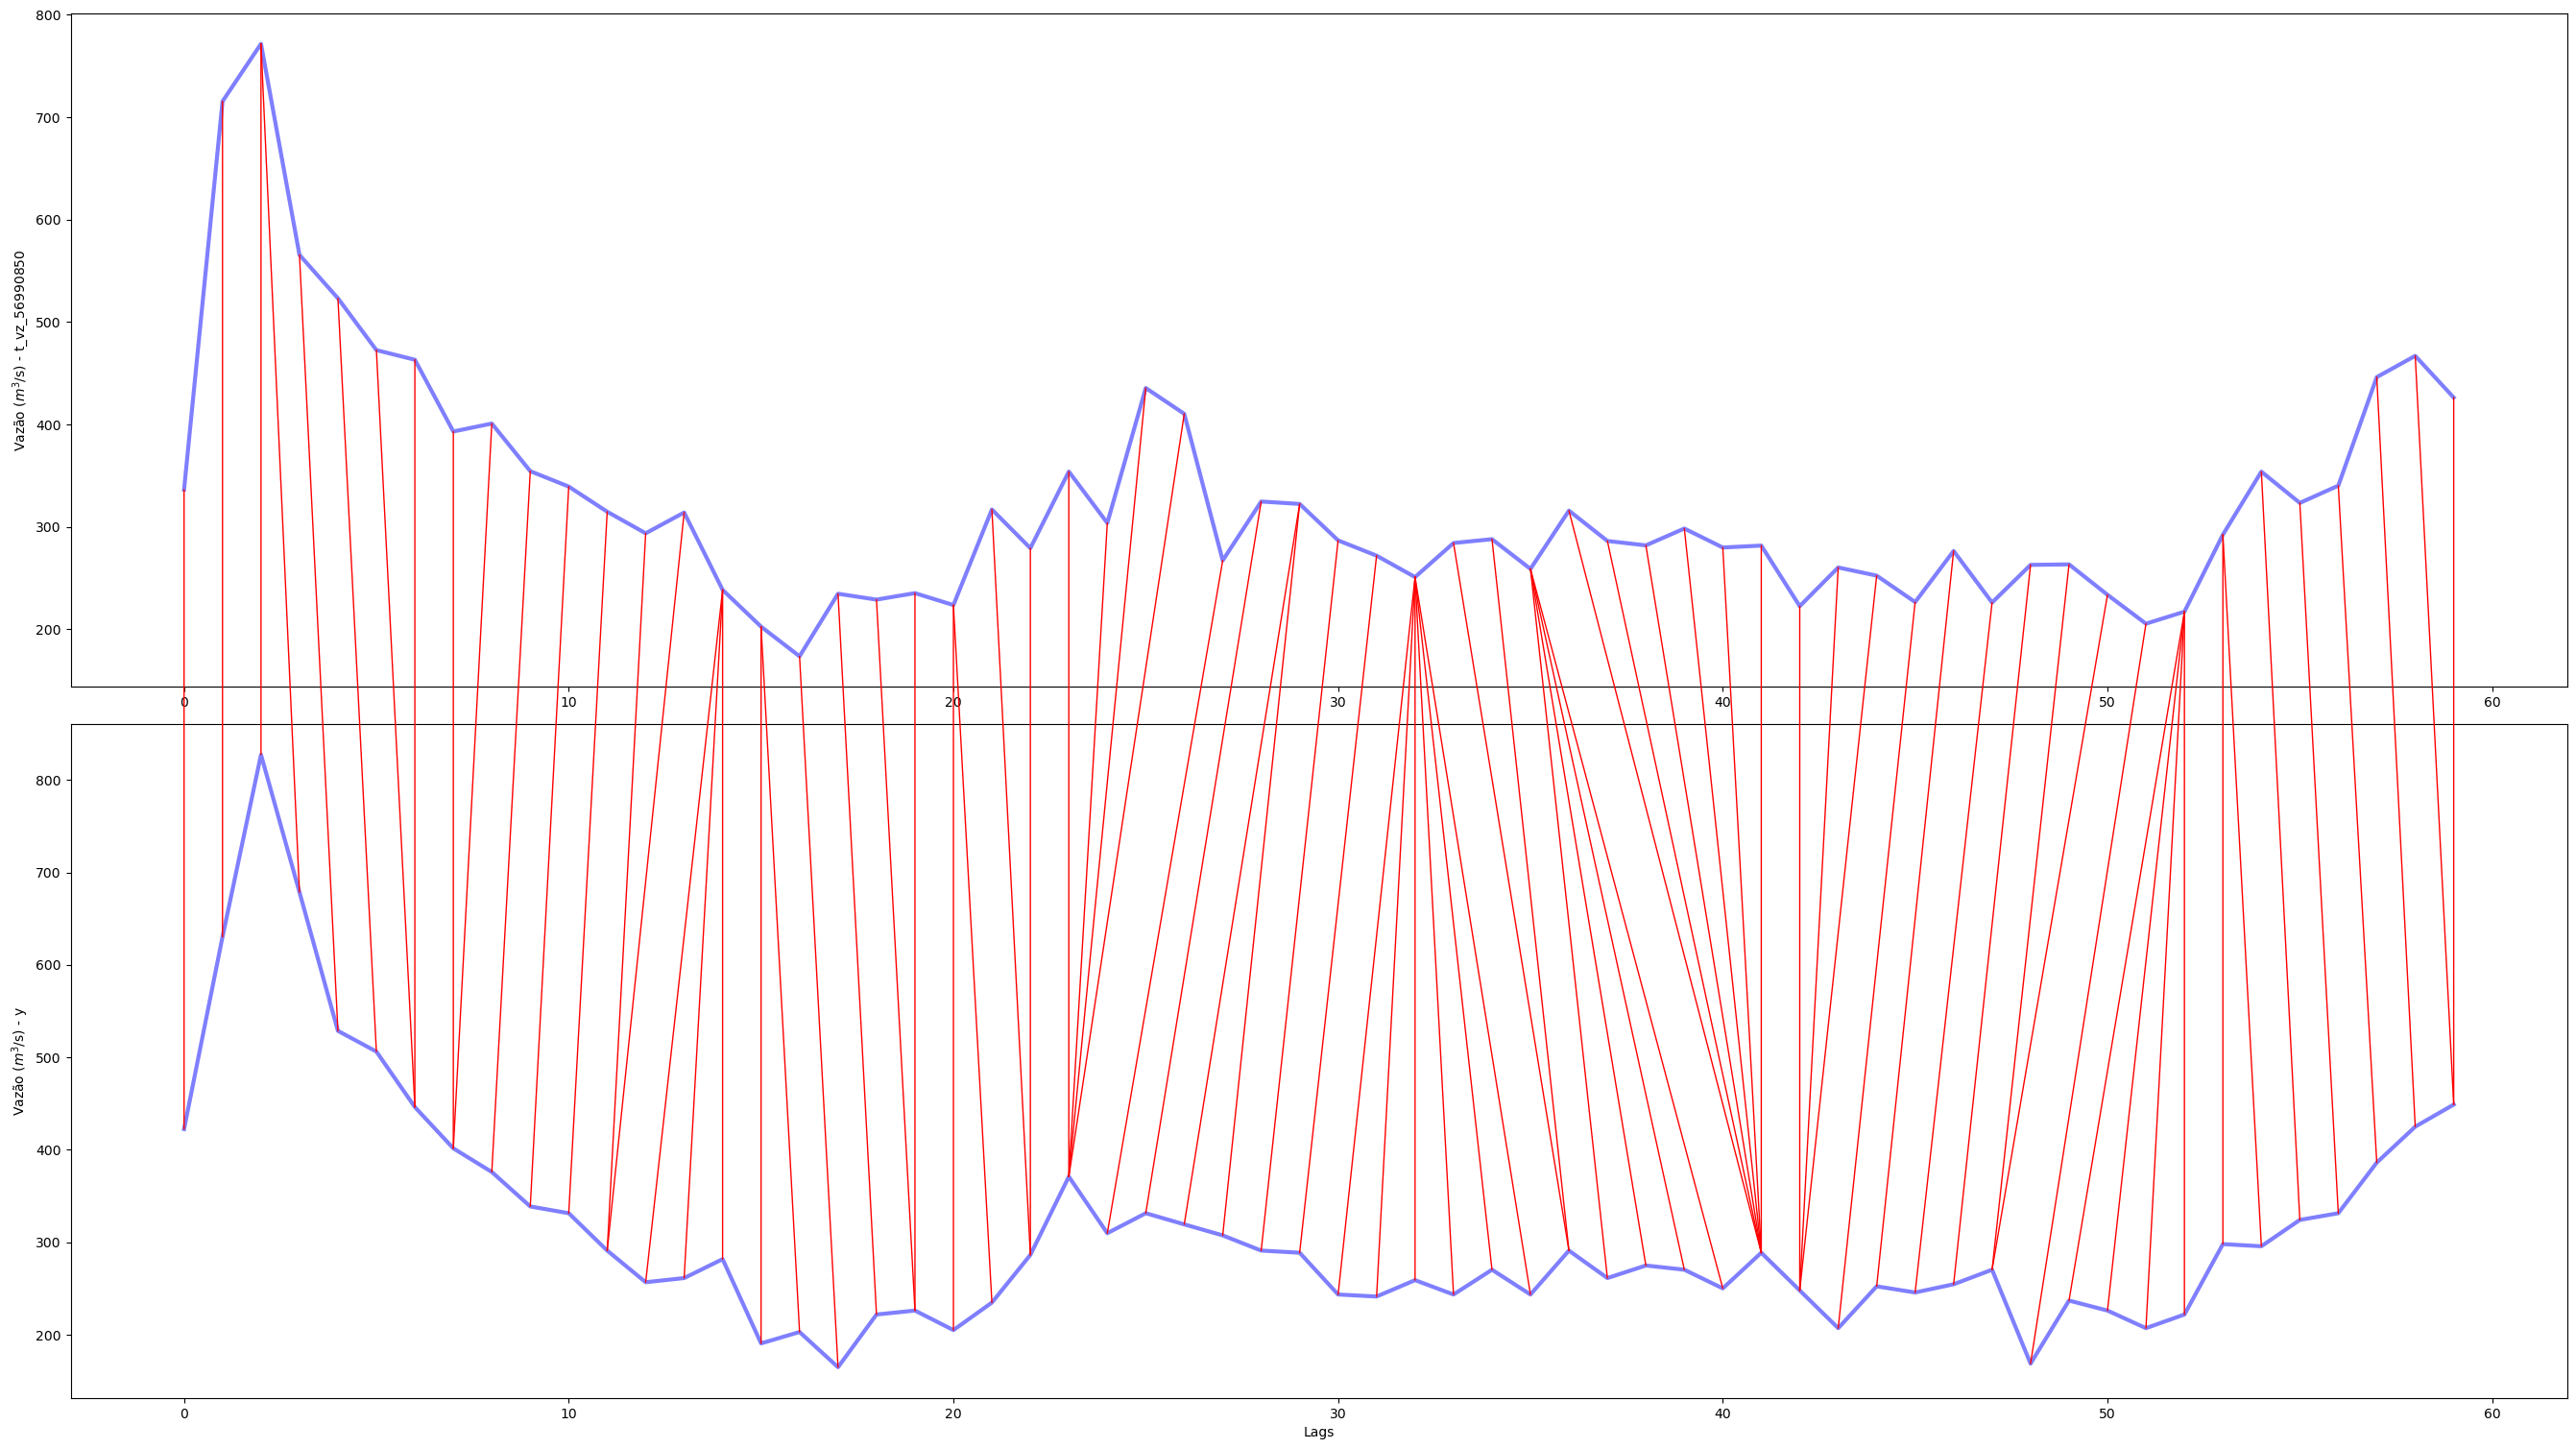

In [28]:
import matplotlib.pyplot as plt
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtw_vis

dtw_dist = dtw.distance_matrix_fast(df_aux.drop(columns=["ds", "unique_id"]).T.values)

df_dtw_dist = pd.DataFrame(
    data=dtw_dist,
    index=df_aux.drop(columns=["ds", "unique_id"]).columns.to_list(),
    columns=df_aux.drop(columns=["ds", "unique_id"]).columns.to_list(),
)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(2560 / 96, 1440 / 96),
)

path = dtw.warping_path(
    from_s=df_aux["t_vz_56990850"].tail(60).T.values,
    to_s=df_aux["y"].tail(60).T.values,
)

dtw_vis.plot_warping(
    s1=df_aux["t_vz_56990850"].tail(60).T.values,
    s2=df_aux["y"].tail(60).T.values,
    path=path,
    fig=fig,
    axs=axs,
    series_line_options={
        "linewidth": 3.0,
        "color": "blue",
        "alpha": 0.5
    },
    warping_line_options={
        "linewidth": 1.0,
        "color": "red",
        "alpha": 1.0
    },
)

axs[1].set_xlabel("Lags")
axs[0].set_ylabel("Vazão ($m^3$/s) - t_vz_56990850")
axs[1].set_ylabel("Vazão ($m^3$/s) - y")
fig.show()

## Granger-causality

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests

# vazoes = ["t_vz_56990850", "t_vz_56990005", "c_vz_56989400", "c_vz_56989900", "c_vz_56990000"]
# chuvas = ["c_cv_01941010", "c_cv_01941004", "c_cv_01941006", "t_cv_56990005"]

df_granger = pd.DataFrame()
df_granger = df_aux.drop(columns=["ds", "unique_id"]).diff(1)  # aplica essa diferenciação pra remover qq efeito de tendência
df_granger = df_granger.dropna()

grangercausalitytests(
    x=df_granger[["y", "t_vz_56990850"]].tail(30),
    maxlag=7,
    verbose=True
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6705 , p=0.0031  , df_denom=26, df_num=1
ssr based chi2 test:   chi2=11.9017 , p=0.0006  , df=1
likelihood ratio test: chi2=9.9724  , p=0.0016  , df=1
parameter F test:         F=10.6705 , p=0.0031  , df_denom=26, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6819  , p=0.0197  , df_denom=23, df_num=2
ssr based chi2 test:   chi2=11.3994 , p=0.0033  , df=2
likelihood ratio test: chi2=9.5633  , p=0.0084  , df=2
parameter F test:         F=4.6819  , p=0.0197  , df_denom=23, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8995  , p=0.0604  , df_denom=20, df_num=3
ssr based chi2 test:   chi2=11.7429 , p=0.0083  , df=3
likelihood ratio test: chi2=9.7500  , p=0.0208  , df=3
parameter F test:         F=2.8995  , p=0.0604  , df_denom=20, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9041  , p=0.1561  , df_d

{1: ({'ssr_ftest': (10.670513931104564, 0.003053119829945064, 26.0, 1),
   'ssr_chi2test': (11.901727077001244, 0.0005608192143902098, 1),
   'lrtest': (9.972417310776734, 0.0015890273186223015, 1),
   'params_ftest': (10.670513931104564, 0.003053119829945064, 26.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.681889632530306, 0.019687427154453305, 23.0, 2),
   'ssr_chi2test': (11.399383453117268, 0.0033469970887616335, 2),
   'lrtest': (9.56327841302982, 0.008382247465140094, 2),
   'params_ftest': (4.681889632530321, 0.019687427154453093, 23.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.8994819762356627, 0.06035400326409866, 20.0, 3),
   'ssr_chi2test': (11.742902003754434, 0.008317821941806806, 3),
   'lrtest': (9.749988870838479, 0.020815358962616746, 3),
   'params_ftest': (2.8994819762356614, 0.060354003264098725, 20.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
         

# Variáveis globais

In [42]:
look_back = 10  # Lags a serem utilizadas. Uma semana passada.

fh_v = [1, 3, 7, 15]  # Horizonte de Previsão (como a frequência dos dados é diária, isso significa "fch" dias)

fh_artigo = [1, 3, 7]  # Horizonte de Previsão inspirado no artigo da Alemanha

intervalos_previsao = [85, 95]

colunas_chuva = ['c_cv_01941010', 'c_cv_01941004', 'c_cv_01941006', 't_cv_56990005']
colunas_vazao = ['t_vz_56990850', 't_vz_56990005', 'c_vz_56989400', 'c_vz_56989900', 'c_vz_56990000']

# Separação dos dados

In [31]:
# Criação de um conjunto de validação de apenas 30 registros (último mês de dados na base de dados)
# Será com este conjunto que as previsões serão realizadas.
# Nos conjuntos de treino/teste farei a otimização da pilha de modelos e gerarei os dados de input para o meta-regressor

df_valid = df_aux.tail(30).copy()
df_valid

,ds,unique_id,y,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56990005,t_vz_56990850,t_vz_56990005,c_vz_56989400,c_vz_56989900,c_vz_56990000
3987,2023-12-02,1,243.630,0.206398,0.781778,0.9,0.4,286.816667,30.717391,12.349919,30.393565,33.103160
3988,2023-12-03,1,241.438,0.000000,0.000000,0.0,0.0,271.904167,29.647826,10.616089,26.333481,30.256082
3989,2023-12-04,1,259.155,0.000000,0.000000,0.0,0.0,250.995833,35.608696,11.387436,23.920729,35.160921
3990,2023-12-05,1,243.630,0.084142,0.000000,0.0,0.0,284.254167,45.008696,12.281543,31.566683,34.775186
3991,2023-12-06,1,270.433,0.000000,0.000000,0.0,0.0,287.991304,37.857143,10.135835,38.817263,36.869529
3992,2023-12-07,1,243.630,0.000000,0.000000,0.0,0.0,258.970833,35.391304,11.009968,20.041494,31.399266
3993,2023-12-08,1,291.120,0.745125,0.000000,0.0,0.0,315.875000,31.630435,15.489399,43.694691,46.404333
3994,2023-12-09,1,261.399,0.000000,1.000000,0.0,0.8,286.250000,31.326087,11.387436,28.133862,35.160921
3995,2023-12-10,1,274.987,0.090008,0.169936,0.8,0.0,281.950000,31.265217,12.527619,28.478301,38.630583
3996,2023-12-11,1,270.433,0.000000,0.000000,0.0,0.0,298.387500,37.000000,10.135817,38.817285,36.869514


In [32]:
df_aux_crpd = df_aux.drop(index=df_valid.index)
df_aux_crpd

,ds,unique_id,y,c_cv_01941010,c_cv_01941004,c_cv_01941006,t_cv_56990005,t_vz_56990850,t_vz_56990005,c_vz_56989400,c_vz_56989900,c_vz_56990000
0,2013-01-01,1,359.721,0.000000,0.0,0.0,0.000000,285.934206,49.213142,15.094200,44.509582,45.320700
1,2013-01-02,1,369.441,4.400000,0.0,0.0,0.000014,315.544128,41.001884,14.762400,36.848171,38.248000
2,2013-01-03,1,399.210,0.000000,0.0,0.0,0.000000,348.594168,49.786464,14.433200,37.670330,40.540700
3,2013-01-04,1,369.441,0.000000,0.0,0.0,0.000020,304.758312,39.373821,13.782100,38.445250,41.711300
4,2013-01-05,1,350.104,0.000000,0.0,0.0,0.000000,271.220263,44.492068,13.782100,38.401960,38.248000
...,...,...,...,...,...,...,...,...,...,...,...,...
3982,2023-11-27,1,331.514,0.000000,0.0,0.0,0.000000,435.582353,32.435000,18.236804,43.384010,51.295174
3983,2023-11-28,1,319.458,0.000000,0.0,0.0,0.000000,410.383333,34.104545,15.163343,43.999793,43.871193
3984,2023-11-29,1,307.547,0.000000,0.0,0.0,0.000000,267.241667,31.082609,15.414847,34.308161,45.425034
3985,2023-11-30,1,291.120,0.538964,0.0,0.0,0.000000,324.754167,29.719444,15.448405,43.350540,46.823942


In [33]:
df_train, df_test = temporal_train_test_split(
    df_aux_crpd,
    test_size=0.2,
    anchor="start"
)

In [34]:
plot_divisao_treino_teste(
    df_treino=df_train,
    df_teste=df_test,
    col_data="ds",
    col_plot="y",
    salvar=SALVAR_PLOTS
)

In [35]:
# df_aux.columns

# Séries sem Chuva, sem Vazão

O DataFrame tem apenas as colunas "ds", "unique_id", "y". Foram removidas as colunas de vazão à montante e as colunas de chuva.

## StatsForecast

### Baseline - SeasonalNaive

In [36]:
for f in fh_v:

    modelo = SeasonalNaive(season_length=365)

    stfc = StatsForecast(
        df=df_train[['ds', 'unique_id', 'y']],
        models=[modelo],
        freq="D",
        n_jobs=8
    )

    df_preds = stfc.forecast(
        h=f,
        level=intervalos_previsao
    )

    df_merged_naive = pd.merge(
        left=df_preds,
        right=df_test[['ds', 'unique_id', 'y']],
        how="left",
        on=['ds', 'unique_id']
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias]),
    }

    metrics[modelo.alias+"-lo-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
    }

    metrics[modelo.alias+"-hi-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
    }

    metrics[modelo.alias+"-lo-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
    }

    metrics[modelo.alias+"-hi-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-95"],
            mode="lines+markers",
            name="SN-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-95"],
            mode="lines+markers",
            name="SN-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-85"],
            mode="lines+markers",
            name="SN-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-85"],
            mode="lines+markers",
            name="SN-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias],
            mode="lines+markers",
            name="SN",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"sem_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## MLForecast

### Baseline - Decision Tree

O emprego de Árvore de Decisão deve-se à característica do modelo em ser agnóstico à escala dos dados.

In [37]:
for f in fh_v:
    dt = DecisionTreeRegressor(random_state=SEED)

    fcst = mlf.MLForecast(
        models=[dt],
        freq="D",
        lags=[i + 1 for i in range(look_back)], # lags apenas na coluna target "y"
        num_threads=8,
        date_features=["dayofyear", "week", "month", "quarter", "year"],
    )

    fcst.fit(
        df=df_train[["ds", "unique_id", "y"]],
        id_col="unique_id",
        time_col="ds",
        target_col="y",
        static_features=[],
        prediction_intervals=PredictionIntervals(h=f, n_windows=10),
    )

    df_preds = fcst.predict(
        h=f,
        level=intervalos_previsao,
    )

    df_result = pd.merge(
        left=df_preds,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left"
    )

    metrics = {}
    metrics["DecisionTreeRegressor"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor"]),
    }

    metrics["DecisionTreeRegressor-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
    }

    metrics["DecisionTreeRegressor-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
    }

    metrics["DecisionTreeRegressor-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
    }

    metrics["DecisionTreeRegressor-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-95"],
            mode="lines+markers",
            name="DT-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-95"],
            mode="lines+markers",
            name="DT-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-85"],
            mode="lines+markers",
            name="DT-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-85"],
            mode="lines+markers",
            name="DT-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor"],
            mode="lines+markers",
            name="DT",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="DecisionTreeRegressor (fh={fh})".format(fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"sem_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md="DecisionTreeRegressor",
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## NeuralForecast

### Main model - LSTM

Este é o modelo que se pretende aplicar no trabalho

In [38]:
for f in fh_v:

    prmtrs_rede = {
        "h": f,
        "random_seed": SEED,
        "context_size": look_back,
        "loss": MQLoss(level=intervalos_previsao),
        "scaler_type": "minmax",
        "encoder_n_layers": 2,
        "encoder_hidden_size": 256,
        "decoder_layers": 2,
        "decoder_hidden_size": 256,
        "logger": False,
        "alias": "LSTM",
        "early_stop_patience_steps": 10,
        "val_check_steps": 25,
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_progress_bar": False,
    }

    modelo = LSTM(**prmtrs_rede)

    nf = NeuralForecast(
        models=[modelo],
        freq="D"
    )

    nf.fit(
        df=df_train[["ds", "unique_id", "y"]],
        val_size=25,
    )

    df_preds = nf.predict()

    df_result = pd.merge(
        left=df_preds,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left",
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-median"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-median"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-median"]),
    }

    metrics[modelo.alias + "-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-85"]),
    }

    metrics[modelo.alias + "-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-85"]),
    }

    metrics[modelo.alias + "-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-95"]),
    }

    metrics[modelo.alias + "-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-95"],
            mode="lines+markers",
            name=modelo.alias + "-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-95"],
            mode="lines+markers",
            name=modelo.alias + "-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-85"],
            mode="lines+markers",
            name=modelo.alias + "-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-85"],
            mode="lines+markers",
            name=modelo.alias + "-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-median"],
            mode="lines+markers",
            name=modelo.alias,
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(
        hovertemplate=None,
        row=1,
        col=1
    )

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"sem_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

Seed set to 1984


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 791 K 
4 | context_adapter | Linear        | 2.6 K 
5 | mlp_decoder     | MLP           | 4.1 K 
--------------------------------------------------
798 K     Trainable para

# Séries com Chuva, sem Vazão

Tem as features exógenas apenas de chuva, sem dados de vazão à montante.

## StatsForecast

### Baseline - SeasonalNaive

Isso não é um preditor de fato. Ao menos, não se considera assim. Serve como uma baseline a superar.

In [43]:
for f in fh_v:
    modelo = SeasonalNaive(season_length=365)

    stfc = StatsForecast(
        df=df_train.drop(columns=colunas_vazao),
        models=[modelo],
        freq="D",
        n_jobs=8
    )

    df_preds = stfc.forecast(
        h=f,
        level=intervalos_previsao)

    df_merged_naive = pd.merge(
        left=df_preds,
        right=df_test[['ds', 'unique_id', 'y']],
        how="left",
        on=['ds', 'unique_id']
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias]),
    }

    metrics[modelo.alias+"-lo-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
    }

    metrics[modelo.alias+"-hi-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
    }

    metrics[modelo.alias+"-lo-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
    }

    metrics[modelo.alias+"-hi-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-95"],
            mode="lines+markers",
            name="SN-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-95"],
            mode="lines+markers",
            name="SN-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-85"],
            mode="lines+markers",
            name="SN-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-85"],
            mode="lines+markers",
            name="SN-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias],
            mode="lines+markers",
            name="SN",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## MLForecast

### Baseline - Decision Tree

O emprego de Árvore de Decisão deve-se à característica do modelo em ser agnóstico à escala dos dados.

In [44]:
for f in fh_v:
    dt = DecisionTreeRegressor(random_state=SEED)

    fcst = mlf.MLForecast(
        models=[dt],
        freq="D",
        lags=[i + 1 for i in range(look_back)], # lags apenas na coluna target "y"
        num_threads=8,
        date_features=["dayofyear", "week", "month", "quarter", "year"],
    )

    fcst.fit(
        df=df_train.drop(columns=colunas_vazao),
        id_col="unique_id",
        time_col="ds",
        target_col="y",
        static_features=[],
        prediction_intervals=PredictionIntervals(h=f, n_windows=10),
    )

    df_futr = df_test.drop(columns=['y']+colunas_vazao)

    df_preds = fcst.predict(
        h=f,
        X_df=df_futr,
        level=intervalos_previsao,
    )

    df_result = pd.merge(
        left=df_preds,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left"
    )

    metrics = {}
    metrics["DecisionTreeRegressor"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor"]),
    }

    metrics["DecisionTreeRegressor-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
    }

    metrics["DecisionTreeRegressor-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
    }

    metrics["DecisionTreeRegressor-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
    }

    metrics["DecisionTreeRegressor-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-95"],
            mode="lines+markers",
            name="DT-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-95"],
            mode="lines+markers",
            name="DT-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-85"],
            mode="lines+markers",
            name="DT-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-85"],
            mode="lines+markers",
            name="DT-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor"],
            mode="lines+markers",
            name="DT",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="DecisionTreeRegressor (fh={fh})".format(fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md="DecisionTreeRegressor",
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## NeuralForecast

### Main model - LSTM

Este é o modelo que se pretende aplicar no trabalho

In [52]:
for f in fh_v:

    prmtrs_rede = {
        "h": f,
        "random_seed": SEED,
        "context_size": look_back,
        "loss": MQLoss(level=intervalos_previsao),
        "futr_exog_list": colunas_chuva,
        "scaler_type": "minmax",
        "encoder_n_layers": 2,
        "encoder_hidden_size": 256,
        "decoder_layers": 2,
        "decoder_hidden_size": 256,
        "logger": False,
        "alias": "LSTM",
        "early_stop_patience_steps": 10,
        "val_check_steps": 25,
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_progress_bar": False,
    }

    modelo = LSTM(**prmtrs_rede)

    nf = NeuralForecast(
        models=[modelo],
        freq="D"
    )

    nf.fit(
        df=df_train.drop(columns=colunas_vazao),
        val_size=25,
    )

    df_preds = nf.predict(
        futr_df=df_test[["ds", "unique_id"]+colunas_chuva]
    )

    df_result = pd.merge(
        left=df_preds,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left",
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-median"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-median"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-median"]),
    }

    metrics[modelo.alias + "-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-85"]),
    }

    metrics[modelo.alias + "-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-85"]),
    }

    metrics[modelo.alias + "-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-95"]),
    }

    metrics[modelo.alias + "-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-95"],
            mode="lines+markers",
            name=modelo.alias + "-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-95"],
            mode="lines+markers",
            name=modelo.alias + "-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-85"],
            mode="lines+markers",
            name=modelo.alias + "-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-85"],
            mode="lines+markers",
            name=modelo.alias + "-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-median"],
            mode="lines+markers",
            name=modelo.alias,
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(
        hovertemplate=None,
        row=1,
        col=1
    )

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_sem_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

Seed set to 1984
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 791 K 
4 | context_adapter | Linear        | 2.6 K 
5 | mlp_decoder     | MLP           | 5.1 K 
--------------------------------------------------
799 K     Trainable params
5         Non-trainable params
799 K     Total params
3.197     Total estimated model params size (MB)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, usi

# Séries com Chuva, com Vazão

## StatsForecast

### Baseline - SeasonalNaive

Isso não é um preditor de fato. Ao menos, não se considera assim. Serve como uma baseline a superar.

In [55]:
for f in fh_v:

    modelo = SeasonalNaive(season_length=365)

    stfc = StatsForecast(
        df=df_train,
        models=[modelo],
        freq="D",
        n_jobs=8
    )

    df_preds = stfc.forecast(
        h=f,
        level=intervalos_previsao)

    df_merged_naive = pd.merge(
        left=df_preds,
        right=df_test[['ds', 'unique_id', 'y']],
        how="left",
        on=['ds', 'unique_id']
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias]),
    }

    metrics[modelo.alias+"-lo-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-85"]),
    }

    metrics[modelo.alias+"-hi-85"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-85"]),
    }

    metrics[modelo.alias+"-lo-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-lo-95"]),
    }

    metrics[modelo.alias+"-hi-95"] = {
        "MAPE": mape(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "RMSE": rmse(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
        "MAE": mae(df_merged_naive["y"], df_merged_naive[modelo.alias+"-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-95"],
            mode="lines+markers",
            name="SN-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-95"],
            mode="lines+markers",
            name="SN-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-hi-85"],
            mode="lines+markers",
            name="SN-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias+"-lo-85"],
            mode="lines+markers",
            name="SN-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive[modelo.alias],
            mode="lines+markers",
            name="SN",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_merged_naive["ds"],
            y=df_merged_naive["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_com_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## MLForecast

### Baseline - Decision Tree

O emprego de Árvore de Decisão deve-se à característica do modelo em ser agnóstico à escala dos dados.

In [56]:
for f in fh_v:
    dt = DecisionTreeRegressor(random_state=SEED)

    fcst = mlf.MLForecast(
        models=[dt],
        freq="D",
        lags=[i + 1 for i in range(look_back)], # lags apenas na coluna target "y"
        num_threads=8,
        date_features=["dayofyear", "week", "month", "quarter", "year"],
    )

    fcst.fit(
        df=df_train,
        id_col="unique_id",
        time_col="ds",
        target_col="y",
        static_features=[],
        prediction_intervals=PredictionIntervals(h=f, n_windows=10),
    )

    df_futr = df_test.drop(columns=["y"])

    df_p = fcst.predict(
        h=f,
        X_df=df_futr,
        level=intervalos_previsao,
    )

    df_result = pd.merge(
        left=df_p,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left"
    )

    metrics = {}
    metrics["DecisionTreeRegressor"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor"]),
    }

    metrics["DecisionTreeRegressor-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-85"]),
    }

    metrics["DecisionTreeRegressor-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-85"]),
    }

    metrics["DecisionTreeRegressor-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-lo-95"]),
    }

    metrics["DecisionTreeRegressor-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
        "MAE": mae(df_result["y"], df_result["DecisionTreeRegressor-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-95"],
            mode="lines+markers",
            name="DT-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-95"],
            mode="lines+markers",
            name="DT-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-hi-85"],
            mode="lines+markers",
            name="DT-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor-lo-85"],
            mode="lines+markers",
            name="DT-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["DecisionTreeRegressor"],
            mode="lines+markers",
            name="DT",
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(hovertemplate=None, row=1, col=1)

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="DecisionTreeRegressor (fh={fh})".format(fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_com_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md="DecisionTreeRegressor",
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

## NeuralForecast

### Main model - LSTM

Este é o modelo que se pretende aplicar no trabalho

In [57]:
for f in fh_v:

    prmtrs_rede = {
        "h": f,
        "random_seed": SEED,
        "context_size": look_back,
        "loss": MQLoss(level=intervalos_previsao),
        "hist_exog_list": colunas_vazao,
        "futr_exog_list": colunas_chuva,
        "scaler_type": "minmax",
        "encoder_n_layers": 2,
        "encoder_hidden_size": 256,
        "decoder_layers": 2,
        "decoder_hidden_size": 256,
        "logger": False,
        "alias": "LSTM",
        "early_stop_patience_steps": 10,
        "val_check_steps": 25,
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_progress_bar": False,
    }

    modelo = LSTM(**prmtrs_rede)

    nf = NeuralForecast(
        models=[modelo],
        freq="D"
    )

    nf.fit(
        df=df_train,
        val_size=25,
    )

    df_preds = nf.predict(
        futr_df=df_test[["ds", "unique_id"]+colunas_chuva]
    )

    df_result = pd.merge(
        left=df_preds,
        right=df_test[["ds", "unique_id", "y"]],
        on=["ds", "unique_id"],
        how="left",
    )

    metrics = {}
    metrics[modelo.alias] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-median"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-median"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-median"]),
    }

    metrics[modelo.alias + "-lo-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-85"]),
    }

    metrics[modelo.alias + "-hi-85"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-85"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-85"]),
    }

    metrics[modelo.alias + "-lo-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-lo-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-lo-95"]),
    }

    metrics[modelo.alias + "-hi-95"] = {
        "MAPE": mape(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "RMSE": rmse(df_result["y"], df_result[modelo.alias + "-hi-95"]),
        "MAE": mae(df_result["y"], df_result[modelo.alias + "-hi-95"]),
    }

    df_tbl = pd.DataFrame(metrics).T.reset_index(names="Modelo")

    fig = make_subplots(
        rows=2,
        cols=1,
        vertical_spacing=0.2,
        specs=[[{"type": "scatter"}], [{"type": "table"}]],
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-95"],
            mode="lines+markers",
            name=modelo.alias + "-hi-95",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-95"],
            mode="lines+markers",
            name=modelo.alias + "-lo-95",
            fill="tonexty",
            line=dict(color="green"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-hi-85"],
            mode="lines+markers",
            name=modelo.alias + "-hi-85",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-lo-85"],
            mode="lines+markers",
            name=modelo.alias + "-lo-85",
            fill="tonexty",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result[modelo.alias + "-median"],
            mode="lines+markers",
            name=modelo.alias,
            line=dict(color="magenta", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_result["ds"],
            y=df_result["y"],
            mode="lines+markers",
            name="observado",
            line=dict(color="black", width=4),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Table(
            header=dict(
                values=df_tbl.columns.to_list(),
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=df_tbl.T,
                font=dict(size=12),
                height=24,
                align="left"
            ),
        ),
        row=2,
        col=1,
    )

    fig.update_yaxes(
        title=dict(text="Vazão (m³/s)", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_xaxes(
        title=dict(text="Período", font=dict(family="system-ui", size=18)),
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
    )

    fig.update_traces(
        hovertemplate=None,
        row=1,
        col=1
    )

    fig.update_layout(
        width=1500,
        height=1000,
        plot_bgcolor="#c8d4e3",
        hovermode="x unified",
        title=dict(
            text="{md} (fh={fh})".format(md=modelo.alias, fh=f),
            font=dict(family="system-ui", size=24),
        ),
    )

    if SALVAR_PLOTS:
        now = datetime.now()
        fig.write_image(
            pasta_resultados+"com_chuva_com_vazao/{md}_fh{fh}_{dt}.png".format(
                fh=f,
                md=modelo.alias,
                dt=now.strftime("%Y-%m-%d_%H-%M-%S")
            )
        )
    else:
        fig.show()

Seed set to 1984
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 796 K 
4 | context_adapter | Linear        | 2.6 K 
5 | mlp_decoder     | MLP           | 5.1 K 
--------------------------------------------------
804 K     Trainable params
5         Non-trainable params
804 K     Total params
3.218     Total estimated model params size (MB)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, usi

# Keras

## LSTM

In [58]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras

In [59]:
keras.__version__

'3.3.3'